<h1 align="center"> Data Pre-Pocessing</h1> <br>

In [2]:
from IPython.display import HTML
from IPython.display import Image

# Reference Code: Arun Godwin Patel Stacking House Prices - Walkthrough to Top 5%


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to show/hide code"></form>''')

In [1]:
# Import the libraries
import numpy as np 
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
from subprocess import check_output

In [3]:
# Read the dataset
df = pd.read_csv('loan.csv', low_memory = False)
#Return a random sample of items - 10% so the dataset is easy to work with
df_sample = df.sample(frac = 0.1)
df_sample_1 = pd.DataFrame(df_sample)

In [4]:
#Analyze target variable - loan_status
df_sample['loan_status'].value_counts()

Current                                                60346
Fully Paid                                             20760
Charged Off                                             4424
Late (31-120 days)                                      1158
Issued                                                   786
In Grace Period                                          614
Late (16-30 days)                                        250
Does not meet the credit policy. Status:Fully Paid       185
Default                                                  147
Does not meet the credit policy. Status:Charged Off       68
Name: loan_status, dtype: int64

In [5]:
#short-cut to get rid of re-loading original data -- you may restart here
df_sample=df_sample_1

In [6]:
#getting rid of loans with statuses we do not care about
#we do not care about current loans 
#we only care about those loans that are either fully paid or are paid very late
#too little examples with "does not meet the credit policy" to care about these...
mask = df_sample['loan_status'].isin(['Fully Paid','Charged Off','Default'])
df_sample = df_sample[mask]
df_sample['loan_status'].value_counts()

Fully Paid     20760
Charged Off     4424
Default          147
Name: loan_status, dtype: int64

In [7]:
# now we only work with loans that are either fully paid or late > 121 days
# We create target variable with these two possible values. Positive class
# are late loans - we care about these and want to analyze in detail. 

def CreateTarget(status): 
    if status == 'Fully Paid':
        return 0
    else:
        return 1
    
df_sample['Late_Loan'] = df_sample['loan_status'].map(CreateTarget)
df_sample['Late_Loan'].value_counts()

0    20760
1     4571
Name: Late_Loan, dtype: int64

In [8]:
#drop features with more than 25% missing values
features_missing_series = df_sample.isnull().sum() > len(df_sample)*0.25
features_missing_series = features_missing_series[features_missing_series == True]
features_missing_list =  features_missing_series.index.tolist()
df_sample = df_sample.drop(features_missing_list,axis =1)

# drop features that have no or little predictive power and original target
df_sample = df_sample.drop(['id','member_id','loan_status','url','zip_code','policy_code','application_type','issue_d','last_pymnt_d','last_credit_pull_d','verification_status','pymnt_plan','funded_amnt','funded_amnt_inv','sub_grade','out_prncp','out_prncp_inv','total_pymnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','initial_list_status','earliest_cr_line','emp_title','title'],axis =1)

#replace missing values with Unknown value or mean when feature is numerical
df_sample['revol_util'].fillna(df_sample['revol_util'].mean(),inplace = True)
df_sample['collections_12_mths_ex_med'].fillna(df_sample['collections_12_mths_ex_med'].mean(),inplace = True)

#new numerical emp_length feature
def EmpLength(length):
    if length == '< 1 year':
        return 0.5
    elif length == '10+ years':
        return 10
    elif length == '1 year':
        return 1
    elif length == '2 years':
        return 2
    elif length == '3 years':
        return 3
    elif length == '4 years':
        return 4
    elif length == '5 years':
        return 5
    elif length == '6 years':
        return 6
    elif length == '7 years':
        return 7
    elif length == '8 years':
        return 8
    elif length == '9 years':
        return 9
    else: #assuming that if not filled out employments was < 1 
        return 0.5    
df_sample['emp_length_num'] = df_sample['emp_length'].map(EmpLength)
df_sample = df_sample.drop('emp_length',axis =1 )

#Convert 'grade' into integer/ order matters
def GradeInt(x):
    if x == "A":
        return 1
    elif x == "B":
        return 2
    elif x == "C":
        return 3
    elif x == "D":
        return 4
    elif x == "E":
        return 5
    else:
        return 6
df_sample['GradeInt'] = df_sample['grade'].map(GradeInt)
df_sample = df_sample.drop('grade',axis =1 )

In [9]:
# Hot encode some categorical features 
columns = ['term', 'home_ownership', 'addr_state','purpose']
for col in columns:
    tmp_df = pd.get_dummies(df_sample[col], prefix=col)
    df_sample = pd.concat((df_sample,tmp_df), axis=1)
# Drop attributes that we hot-encoded
df_sample = df_sample.drop(['term', 'home_ownership', 'addr_state','purpose'], axis=1)

In [10]:
df_sample.isnull().sum() #there are no missing values left 

loan_amnt                     0
int_rate                      0
installment                   0
annual_inc                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
Late_Loan                     0
emp_length_num                0
GradeInt                      0
term_ 36 months               0
term_ 60 months               0
home_ownership_MORTGAGE       0
home_ownership_NONE           0
home_ownership_OTHER          0
home_ownership_OWN            0
home_ownership_RENT           0
addr_state_AK                 0
addr_state_AL                 0
addr_state_AR                 0
addr_state_AZ                 0
addr_state_CA                 0
addr_state_CO                 0
                             ..
addr_sta

In [11]:
#datatypes of features 
# object = string ? 
df_sample.dtypes.value_counts()

uint8      69
float64    15
int64       2
dtype: int64

In [2]:
from IPython.display import HTML
from IPython.display import Image

# Reference Code: Arun Godwin Patel Stacking House Prices - Walkthrough to Top 5%


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to show/hide code"></form>''')

In [12]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25331 entries, 791120 to 95464
Data columns (total 86 columns):
loan_amnt                     25331 non-null float64
int_rate                      25331 non-null float64
installment                   25331 non-null float64
annual_inc                    25331 non-null float64
dti                           25331 non-null float64
delinq_2yrs                   25331 non-null float64
inq_last_6mths                25331 non-null float64
open_acc                      25331 non-null float64
pub_rec                       25331 non-null float64
revol_bal                     25331 non-null float64
revol_util                    25331 non-null float64
total_acc                     25331 non-null float64
collections_12_mths_ex_med    25331 non-null float64
acc_now_delinq                25331 non-null float64
Late_Loan                     25331 non-null int64
emp_length_num                25331 non-null float64
GradeInt                      25331 non-

In [13]:
#df_sample.to_csv(
#    "C://Users//tangzhengback//Desktop//df_sample.csv"
#)

#  START HERE

In [3]:
#You may ignore the codes above(don't run). But before you begin, please follow the following steps:
#Step 1: check whether df_sample.csv is in the repository. If not, upload it.
#Step 2：run this cell.

df_sample = pd.read_csv('df_sample.csv', low_memory = False)
df_sample = df_sample.drop([df_sample.columns[0,]],axis=1) 
#Standardize and split the data
y = df_sample.pop('Late_Loan')
column_names = df_sample.columns.values.tolist()
df = df_sample.values
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled)
c = dict(zip(range(df_sample.columns.size),column_names))
df = df.rename(mapper = c, axis = 'columns')
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
# Fitting perceptron to the training data
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=1)
ppn.fit(X_train, y_train)

y_pred = ppn.predict(X_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
score = accuracy_score(y_test, y_pred)    
print (score)

Misclassified samples: 1464
0.8090517803573758


In [5]:
# adjusting the value of hyhyperparameter n_iter
n_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for n in n_range:
    ppn = Perceptron(n_iter=n, eta0=0.1, random_state=1)
    ppn.fit(X_train, y_train)
    y_pred = ppn.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    print (score)

0.8108777879222643
0.7626190165644972
0.7701839050476066
0.8090517803573758
0.7767053606364941
0.6538411373418547
0.8189643928524847
0.6996217555758445
0.8044867614451545
0.6576235815834094


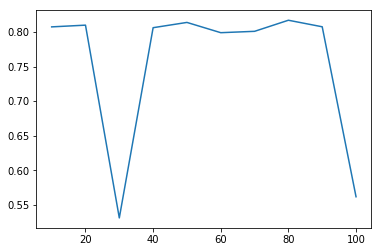

In [6]:
# plot the change of accuracy for different C
import matplotlib.pyplot as plt

x=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracy=[0.8073286052009456, 0.8098240084055687, 0.5311268715524035, 0.806146572104019, 0.8137641187286577, 0.7989230365116889, 0.8008930916732335, 0.816916206987129, 0.8074599422117152, 0.5617283950617284]
plt.plot(x,accuracy)
plt.show()

### From the perceptron results, we find the best accuracy is 0.8169 with n_iter =80

In [7]:
# Fitting Logistic Regression to the training data
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10.0, random_state=1)
lr.fit(X_train, y_train)

# Predicting the results
y_pred = lr.predict(X_test)

# calculating the accuracy score
score = accuracy_score(y_test, y_pred)    
print (score)

0.8168775270640407


In [8]:
# adjusting the value of hyhyperparameter C
c_range = [0.0001, 0.01, 0.1, 1, 10, 100, 1000]
for x in c_range:
    lr = LogisticRegression(C=x, random_state=1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    print (score)

0.8193556801878179
0.8200078257467067
0.818312247293596
0.8175296726229294
0.8168775270640407
0.8164862397287075
0.8164862397287075


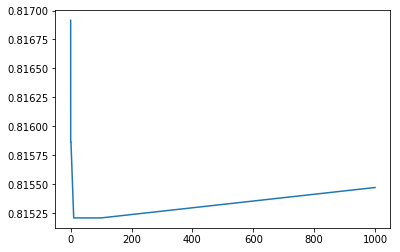

In [9]:
# plot the change of accuracy for different C
import matplotlib.pyplot as plt

x=[0.0001, 0.01, 0.1, 1, 10, 100, 1000]
accuracy=[0.816916206987129, 0.816916206987129, 0.8158655109009719, 0.8158655109009719, 0.8152088258471237, 0.8152088258471237, 0.815471499868663]
plt.plot(x,accuracy)
plt.show()

In [10]:
# from the picture above, we can narrow the range between [0.01, 0.1]
# adjusting the value of hyhyperparameter C
c_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for x in c_range:
    lr = LogisticRegression(C=x, random_state=1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    print (score)

0.8200078257467067
0.8194861092995956
0.8196165384113734
0.8185731055171515
0.8181818181818182
0.8184426764053737
0.818312247293596
0.8181818181818182
0.8181818181818182
0.818312247293596


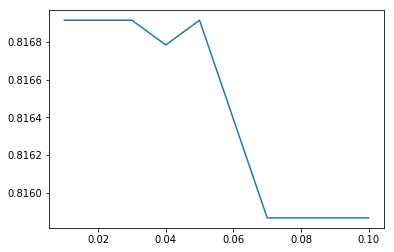

In [11]:
# plot the change of accuracy for C between [0.01, 0.1]
import matplotlib.pyplot as plt

x=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
accuracy=[0.816916206987129, 0.816916206987129, 0.816916206987129, 0.8167848699763594, 0.816916206987129, 0.8163908589440504, 0.8158655109009719, 0.8158655109009719, 0.8158655109009719, 0.8158655109009719]
plt.plot(x,accuracy)
plt.show()

To get the optimal c with best accuracy and relative higher value, we can find c= 0.05

### from the LogisticRegression results, we find the best accuracy is 0.8169 with c=0.05

In [12]:
# Fitting Support vector machines (SVMs) to the training data
# SVC with linear kernel
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=10.0, random_state=1)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

score = accuracy_score(y_test, y_pred)    
print (score)

0.8193556801878179


In [13]:
# SVC with RBF kernel
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
score = accuracy_score(y_test, y_pred) 
print (score)

0.8197469675231511


In [24]:
# adjusting the value of hyhyperparameter gamma
gamma_range = [0.0001, 0.01, 0.1, 1, 10, 100, 1000]
for x in gamma_range:
    svm = SVC(kernel='rbf', random_state=1, gamma=x, C=10.0)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    print (score)

0.816916206987129
0.816916206987129
0.816916206987129
0.8166535329655897
0.7609666403992645
0.8170475439978986
0.816916206987129


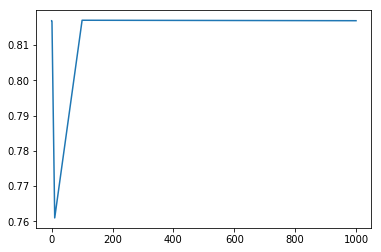

In [28]:
# plot the change of accuracy for different gamma
import matplotlib.pyplot as plt

x=[0.0001, 0.01, 0.1, 1, 10, 100, 1000]
accuracy=[0.816916206987129, 0.816916206987129, 0.816916206987129, 0.8166535329655897, 0.7609666403992645, 0.8170475439978986, 0.816916206987129]
plt.plot(x,accuracy)
plt.show()

In [29]:
# to get the optimal gamma with best accuracy and relative higher value, we can find gamma= 100

### from the Support vector machines (SVMs) results, we find the best accuracy is 0.8170 with c=10, gamma=100

In [67]:
# Fitting KNeighborsClassifier (KNN) to the training data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
score = accuracy_score(y_test, y_pred) 
print (score)

0.7960088691796009


In [26]:
# adjusting the value of K
K_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for k in K_range:
    knn = KNeighborsClassifier(n_neighbors=k, 
                           p=2, 
                           metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    print (score)

0.7248489624376149
0.7977410034147623
0.7705542421854479
0.804307853953244
0.7888100866824271
0.8065405831363278
0.7985290254793801
0.8096926713947991
0.8019437877593906
0.808641975308642
0.8050958760178618
0.8116627265563435
0.8100866824271079
0.8125820856317311
0.8104806934594169


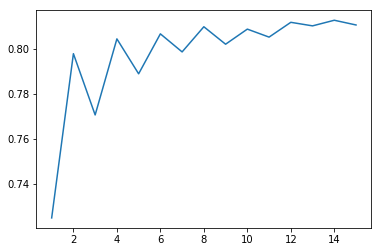

In [68]:
# plot the change of accuracy for different k
import matplotlib.pyplot as plt

k=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracy=[0.7248489624376149, 0.7977410034147623, 0.7705542421854479, 0.804307853953244, 0.7888100866824271, 0.8065405831363278, 0.7985290254793801, 0.8096926713947991, 0.8019437877593906, 0.808641975308642, 0.8050958760178618, 0.8116627265563435, 0.8100866824271079, 0.8125820856317311, 0.8104806934594169]
plt.plot(k,accuracy)
plt.show()

### from KNeighborsClassifier (KNN) results, we find the best accuracy is 0.8126 with k=14
### But from all the results above, we can find that the hyhyperparameter adjustment take little effect on increasing  accuracy

### Decision Tree Classifier
- Accuracy score
- Feature importance
- Plotting decision tree

In [14]:
# Decision tree classifier

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=2333)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [15]:
score = accuracy_score(y_test, y_pred)
print('The accuracy score of decision tree is %.6f' % score)

importance = tree.feature_importances_
column_names = df.columns.values.tolist()
importances = dict(zip(importance, column_names))

important_features = []

for ii in range(len(importance)):
    if ii < 5:
        important_features.append(importances[sorted(importance, reverse = True)[ii]])
        
print('The 5 most important features in decision tree model are: '+str(important_features))

The accuracy score of decision tree is 0.818051
The 5 most important features in decision tree model are: ['int_rate', 'dti', 'annual_inc', 'term_ 60 months', 'term_ 36 months']


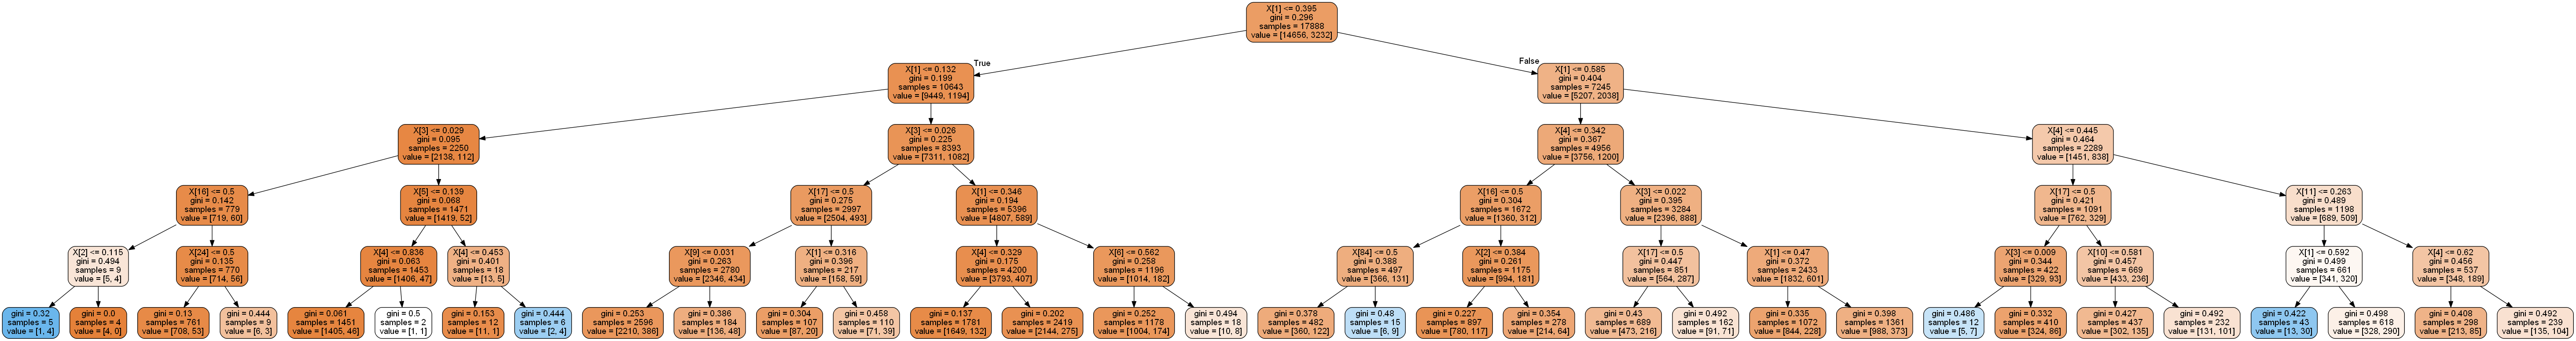

In [16]:
# Plotting decision tree

from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                            filled=True, 
                            rounded=True,
                            out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')

from IPython.display import Image
Image('tree.png', width=1000)

### Bagging Classifier
- Accuracy score

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=3)
bag = BaggingClassifier(base_estimator=tree, 
                        n_estimators=200,
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

bag = bag.fit(X_train, y_train)

y_pred = bag.predict(X_test)
score = accuracy_score(y_test, y_pred)

print('Bagging test accuracy %.6f'% score)

Bagging test accuracy 0.819356


### AdaBoost Classifier
- Accuracy score
- Best number of iterations
- Feature importances

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

iters = np.linspace(10, 300, num=30)
accuracy = []
for ii in iters:
    tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=2)
    ada = AdaBoostClassifier(base_estimator=tree,
                             n_estimators=int(ii),
                             learning_rate=0.1,
                             random_state=1)
    ada = ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    accuracy.append(score)

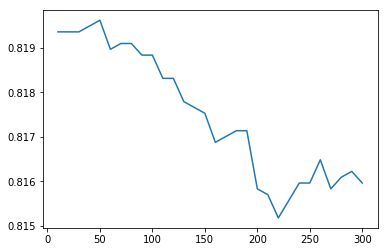

When iterations equals to 50, AdaBoost has the highest accuracy: 0.819617


In [59]:
plt.plot(iters,accuracy)
plt.show()

print('When iterations equals to %d, AdaBoost has the highest accuracy: %.6f' % (iters[accuracy.index(max(accuracy))],max(accuracy)))

In [60]:
tree = DecisionTreeClassifier(criterion='entropy',random_state=1,max_depth=2)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=int(iters[accuracy.index(max(accuracy))]),
                         learning_rate=0.1,
                         random_state=1)
ada = ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

importance = ada.feature_importances_
column_names = df.columns.values.tolist()
importances = dict(zip(importance, column_names))

important_features = []

for ii in range(len(importance)):
    if ii < 5:
        important_features.append(importances[sorted(importance, reverse = True)[ii]])
        
print('The 5 most important features in AdaBoost model under best iteration number are: '+str(important_features))

The 5 most important features in AdaBoost model under best iteration number are: ['int_rate', 'annual_inc', 'dti', 'revol_util', 'term_ 60 months']


 1) int_rate                       0.337495
 2) annual_inc                     0.142173
 3) dti                            0.133373
 4) revol_util                     0.075336
 5) term_ 60 months                0.052220
 6) loan_amnt                      0.047806
 7) purpose_small_business         0.044962
 8) total_acc                      0.043734
 9) installment                    0.028876
10) term_ 36 months                0.027061
11) revol_bal                      0.021277
12) purpose_house                  0.015575
13) home_ownership_MORTGAGE        0.011636
14) addr_state_CA                  0.007754
15) pub_rec                        0.006970
16) inq_last_6mths                 0.003752
17) addr_state_AZ                  0.000000
18) addr_state_IN                  0.000000
19) addr_state_IL                  0.000000
20) addr_state_ID                  0.000000
21) addr_state_KY                  0.000000
22) addr_state_KS                  0.000000
23) addr_state_GA               

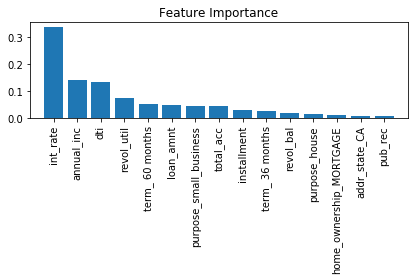

In [61]:
importances = ada.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],importances[indices[f]]))
feat_labels_sorted = []
for ii in range(X_train.shape[1]):
    feat_labels_sorted.append(feat_labels[np.argsort(importances)[::-1][ii]])
plt.title('Feature Importance')
plt.bar(range(15),importances[indices][:15],align='center')
plt.xticks(range(15),feat_labels_sorted, rotation=90)
plt.xlim([-1,15])
#plt.bar(range(X_train.shape[1]),importances[indices],align='center')
#plt.xticks(range(X_train.shape[1]),feat_labels, rotation=90)
#plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

### Random Forest Classifier
- Accuracy score
- Best number of iterations
- Feature importances

In [18]:
from sklearn.ensemble import RandomForestClassifier

iters = np.linspace(10, 300, num=30)
accuracy = []
for ii in iters:
    forest = RandomForestClassifier(criterion='gini',
                                n_estimators=int(ii), 
                                random_state=2333,
                                n_jobs=2)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    accuracy.append(score)

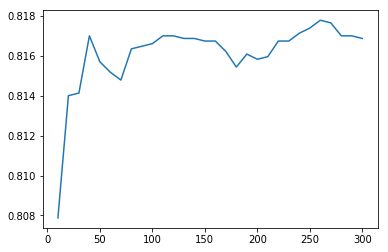

When iterations equals to 260, Random Forest has the highest accuracy: 0.817791


In [19]:
plt.plot(iters,accuracy)
plt.show()

print('When iterations equals to %d, Random Forest has the highest accuracy: %.6f' % (iters[accuracy.index(max(accuracy))], max(accuracy)))

In [20]:
forest = RandomForestClassifier(criterion='gini',
                            n_estimators=int(iters[accuracy.index(max(accuracy))]), 
                            random_state=2333,
                            n_jobs=2)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

importance = forest.feature_importances_
column_names = df.columns.values.tolist()
importances = dict(zip(importance, column_names))

important_features = []

for ii in range(len(importance)):
    if ii < 5:
        important_features.append(importances[sorted(importance, reverse = True)[ii]])
        
print('The 5 most important features in Random Forest model are: '+str(important_features))

The 5 most important features in Random Forest model are: ['int_rate', 'dti', 'annual_inc', 'revol_util', 'revol_bal']


 1) int_rate                       0.085851
 2) dti                            0.082075
 3) annual_inc                     0.074942
 4) revol_util                     0.074673
 5) revol_bal                      0.073836
 6) installment                    0.072579
 7) total_acc                      0.062910
 8) loan_amnt                      0.061680
 9) open_acc                       0.053101
10) emp_length_num                 0.040615
11) GradeInt                       0.034923
12) inq_last_6mths                 0.027989
13) delinq_2yrs                    0.015568
14) purpose_debt_consolidation     0.011459
15) term_ 60 months                0.010963
16) term_ 36 months                0.010926
17) pub_rec                        0.010482
18) addr_state_CA                  0.009904
19) home_ownership_RENT            0.009327
20) purpose_credit_card            0.008841
21) home_ownership_MORTGAGE        0.008829
22) addr_state_NY                  0.007813
23) addr_state_FL               

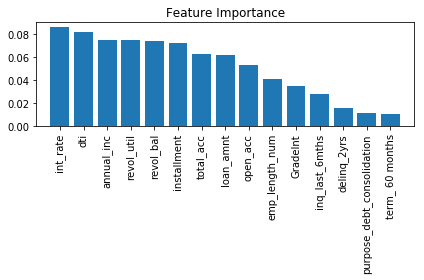

In [56]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],importances[indices[f]]))
feat_labels_sorted = []
for ii in range(X_train.shape[1]):
    feat_labels_sorted.append(feat_labels[np.argsort(importances)[::-1][ii]])
plt.title('Feature Importance')
plt.bar(range(15),importances[indices][:15],align='center')
plt.xticks(range(15),feat_labels_sorted, rotation=90)
plt.xlim([-1,15])
#plt.bar(range(X_train.shape[1]),importances[indices],align='center')
#plt.xticks(range(X_train.shape[1]),feat_labels, rotation=90)
#plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

## Model Evaluation

In [63]:
#Evaluation for perceptron
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=ppn,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.77709497 0.81787709 0.81442146 0.80994969 0.81721632 0.81945221
 0.59284116 0.77404922 0.76118568 0.77852349]
CV accuracy: 0.776 +/- 0.065


In [64]:
#Evaluation for logistic regression
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.81787709 0.82178771 0.82224707 0.82112912 0.82057015 0.82057015
 0.82326622 0.81823266 0.82102908 0.81991051]
CV accuracy: 0.821 +/- 0.002


In [65]:
#Evaluation for SVM
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=svm,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.81843575 0.82011173 0.81945221 0.81945221 0.81945221 0.82001118
 0.8204698  0.81823266 0.81879195 0.81935123]
CV accuracy: 0.819 +/- 0.001


In [69]:
#Evaluation for KNN
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=knn,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.79273743 0.79664804 0.79653438 0.79541643 0.79765232 0.80547792
 0.79250559 0.79138702 0.79474273 0.79642058]
CV accuracy: 0.796 +/- 0.004


In [70]:
#Evaluation for decision tree
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=tree,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.81899441 0.81899441 0.81945221 0.81945221 0.81945221 0.81945221
 0.81935123 0.81935123 0.81935123 0.81935123]
CV accuracy: 0.819 +/- 0.000


In [73]:
#Evaluation for bagging
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=bag,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.81899441 0.81899441 0.81945221 0.81945221 0.81945221 0.81945221
 0.81935123 0.81935123 0.81935123 0.81935123]
CV accuracy: 0.819 +/- 0.000


In [74]:
#Evaluation for AdaBoost
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=ada,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.81675978 0.82178771 0.82057015 0.81889324 0.82001118 0.82057015
 0.82158837 0.81767338 0.81991051 0.81823266]
CV accuracy: 0.820 +/- 0.002


In [75]:
#Evaluation for random forest
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=forest,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.81675978 0.81675978 0.82112912 0.81833426 0.81833426 0.82057015
 0.82158837 0.81823266 0.8204698  0.81991051]
CV accuracy: 0.819 +/- 0.002


## Conclusion

As shown in the evaluation above, we can see that logistic regression has highest CV accuracy and its variation is relatively small. So, we will use the logistic regression to predict whether a loan will be the default.